In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("data/German_Major_Cities_Hamburg_Berlin_Munich_Colonge_Frankfurt_weather_report_2020_to_2025.csv")
# print(df.head())

In [3]:
print(df.describe())

            tempmax       tempmin          temp  feelslikemax  feelslikemin  \
count  10110.000000  10110.000000  10110.000000  10110.000000  10110.000000   
mean      15.486617      7.531484     11.427656     14.821316      5.992305   
std        8.356544      6.255187      7.090880      9.092120      7.563230   
min       -7.200000    -13.200000     -8.900000    -14.800000    -18.700000   
25%        8.900000      2.700000      6.000000      7.000000      0.000000   
50%       15.300000      7.500000     11.100000     15.300000      5.700000   
75%       22.000000     12.600000     17.200000     22.000000     12.600000   
max       38.200000     24.400000     29.400000     37.200000     24.400000   

          feelslike           dew      humidity        precip    precipprob  \
count  10110.000000  10110.000000  10110.000000  10110.000000  10110.000000   
mean      10.342868      6.258645     73.585796      2.079515     58.665005   
std        8.183343      5.970016     13.144694    

In [4]:
df['name'] = df['name'].replace('Colonge', 'Cologne')

In [5]:
hamburg_df = df[df["name"] == "Hamburg"]
figure = px.line(hamburg_df, x="datetime", 
                 y="temp", 
                 title='Temperature of Hamburg in Over the Years')
figure.show()

In [6]:
figure = px.line(hamburg_df, x="datetime", 
                 y="humidity", 
                 title='Humidity in Hamburg Over the Years')
figure.show()

In [7]:
figure = px.line(hamburg_df, x="datetime", 
                 y="windspeed", 
                 title='Windspeed in Hamburg Over the Years')
figure.show()

In [8]:
df["date"] = pd.to_datetime(df["datetime"], format = '%Y-%m-%d')
df['year'] = df['date'].dt.year
df["month"] = df["date"].dt.month
print(df[["year","month"]].head())

   year  month
0  2020      1
1  2020      1
2  2020      1
3  2020      1
4  2020      1


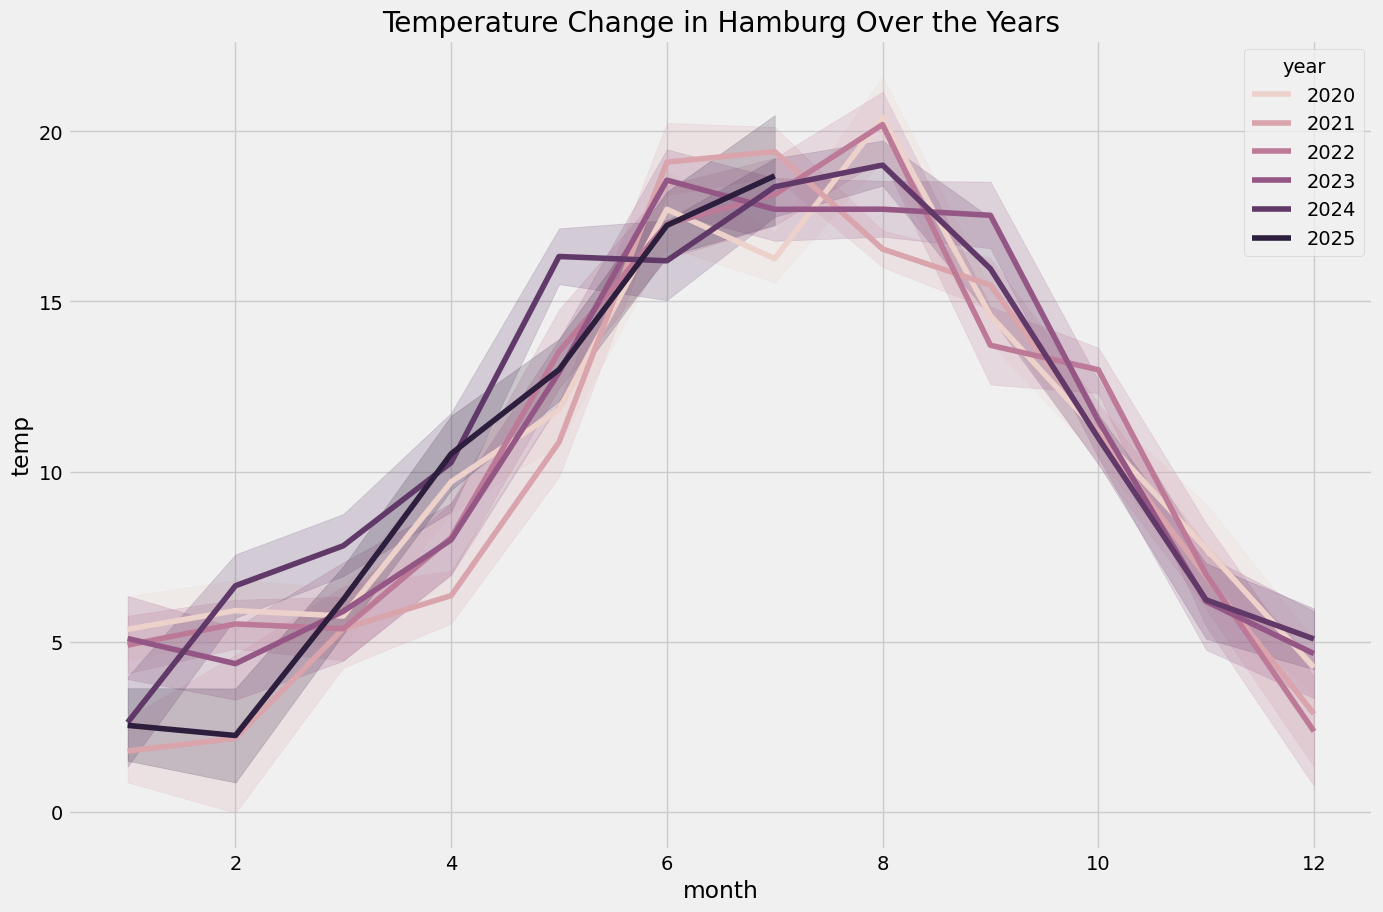

In [9]:
hamburg_df = df[df["name"] == "Hamburg"]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.title("Temperature Change in Hamburg Over the Years")
sns.lineplot(data = hamburg_df, x='month', y='temp', hue='year')
plt.show()

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
#Extract day of year and encode as cyclical features
df['dayofyear'] = df['datetime'].dt.dayofyear
df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
print(df[["sin_dayofyear", "cos_dayofyear" ]])

       sin_dayofyear  cos_dayofyear
0           0.017213       0.999852
1           0.034422       0.999407
2           0.051620       0.998667
3           0.068802       0.997630
4           0.085965       0.996298
...              ...            ...
10105      -0.128748      -0.991677
10106      -0.145799      -0.989314
10107      -0.162807      -0.986658
10108      -0.179767      -0.983709
10109      -0.196673      -0.980469

[10110 rows x 2 columns]


In [11]:
# One-hot encode the city
df = pd.get_dummies(df, columns=['name'], prefix='city')

In [12]:
# Drop unnecessary columns
columns_to_drop = [
    'sunrise', 'sunset', 'stations',
]
df = df.drop(columns=columns_to_drop, errors='ignore')

In [13]:
# Define input features (X)
feature_columns = [
    'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew',
    'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust',
    'winddir', 'cloudcover', 'solarradiation','solarenergy', 
    'uvindex', 'year', 'month', 'sin_dayofyear', 'cos_dayofyear'
] + [col for col in df.columns if col.startswith('city_')]

print(feature_columns)
print(len(feature_columns))

X = df[feature_columns]

# ✅ Regression targets
y_regression = df[['temp', 'humidity', 'precip', 'windspeed', 'feelslike', 'sealevelpressure']]

# ✅ Classification targets (for later)
y_classification = df[['description', 'icon']]


['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'winddir', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'month', 'sin_dayofyear', 'cos_dayofyear', 'city_Berlin', 'city_Cologne', 'city_Frankfurt', 'city_Hamburg', 'city_Munich']
24


In [14]:
# scale input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Initialize encoders
le_description = LabelEncoder()
le_icon = LabelEncoder()

# Apply encoding
y_description = le_description.fit_transform(y_classification['description'])
y_icon = le_icon.fit_transform(y_classification['icon'])

In [16]:
# Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_regression, test_size=0.2, random_state=42
)

# Classification
X_train_cls, X_test_cls, y_train_desc, y_test_desc = train_test_split(
    X_scaled, y_description, test_size=0.2, random_state=42
)

_, _, y_train_icon, y_test_icon = train_test_split(
    X_scaled, y_icon, test_size=0.2, random_state=42
)

print(len(X_train_reg[0]))
print(y_train_reg)

24
      temp  humidity  precip  windspeed  feelslike  sealevelpressure
6013  23.5      64.1   0.012       20.4       23.5            1016.3
1817   5.1      85.0   0.000       13.0        3.6            1020.1
4386   1.9      88.1  16.599       14.7       -1.2            1010.2
9319  20.3      72.3   0.000       31.2       20.3            1022.0
4575  15.8      70.2   2.736       31.6       15.8            1020.3
...    ...       ...     ...        ...        ...               ...
5734   2.6      74.4   0.017       22.8       -1.1            1014.0
5191  11.5      66.7   0.000       15.8       11.1            1020.3
5390  12.1      81.4   0.001        7.4       12.0            1026.6
860    8.1      60.8   0.000        9.0        7.4            1018.0
7270   2.3      87.6  20.443       15.2       -0.5            1004.5

[8088 rows x 6 columns]


In [17]:
# Regression Model (MultiOutput with RandomForest)
from sklearn.metrics import mean_squared_error, r2_score
regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
regressor.fit(X_train_reg, y_train_reg)

y_pred = regressor.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)
print(f"Stage 2 Model MSE: {mse:.4f}")
print(f"Stage 2 Model R²: {r2:.4f}")



Stage 2 Model MSE: 13.2588
Stage 2 Model R²: 0.7842


In [18]:
# Classification Models
clf_desc = RandomForestClassifier(n_estimators=100, random_state=42)
clf_icon = RandomForestClassifier(n_estimators=100, random_state=42)

clf_desc.fit(X_train_cls, y_train_desc)
clf_icon.fit(X_train_cls, y_train_icon)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Ensure the directory exists
os.makedirs("models", exist_ok=True)

# Save models
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(regressor, "models/regressor.pkl")
joblib.dump(clf_desc, "models/description_classifier.pkl")
joblib.dump(clf_icon, "models/icon_classifier.pkl")

# Save encoders
joblib.dump(le_description, "models/label_encoder_description.pkl")
joblib.dump(le_icon, "models/label_encoder_icon.pkl")

print("All models and encoders saved successfully!")

All models and encoders saved successfully!


In [20]:
# import joblib
# import numpy as np
# from datetime import datetime
# import pandas as pd

# # Load models
# scaler = joblib.load("models/scaler.pkl")
# regressor = joblib.load("models/regressor.pkl")
# clf_desc = joblib.load("models/description_classifier.pkl")
# clf_icon = joblib.load("models/icon_classifier.pkl")

# # Load encoders
# le_description = joblib.load("models/label_encoder_description.pkl")
# le_icon = joblib.load("models/label_encoder_icon.pkl")


# sample = {
#     "date": "2024-07-18",
#     "name": "Hamburg",
#     "tempmax": 27,
#     "tempmin": 19,
#     "feelslikemax": 29,
#     "feelslikemin": 20,
#     "dew": 15,
#     "precipprob": 60,
#     "precipcover": 0.2,
#     "snow": 0,
#     "snowdepth": 0,
#     "windgust": 35,
#     "winddir": 180,
#     "cloudcover": 40,
#     "visibility": 10,
#     "solarradiation": 230,
#     "solarenergy": 18,
#     "uvindex": 6
# }

# # Extract date features
# dt = datetime.strptime(sample["date"], "%Y-%m-%d")
# year = dt.year
# month = dt.month
# dayofyear = dt.timetuple().tm_yday
# sin_dayofyear = np.sin(2 * np.pi * dayofyear / 365)
# cos_dayofyear = np.cos(2 * np.pi * dayofyear / 365)

# # City one-hot encoding (manual, since you used pd.get_dummies)
# cities = ['city_Berlin', 'city_Cologne', 'city_Frankfurt', 'city_Hamburg', 'city_Munich']

# city_vector = [1 if f"city_{sample['name']}" == city else 0 for city in cities]

# # Create feature vector in correct order
# X_input = np.array([
#     sample['tempmax'], sample['tempmin'], sample['feelslikemax'], sample['feelslikemin'],
#     sample['dew'], sample['precipprob'], sample['precipcover'], sample['snow'], sample['snowdepth'],
#     sample['windgust'], sample['winddir'], sample['cloudcover'], sample['solarradiation'],
#     sample['solarenergy'], sample['uvindex'], year, month, sin_dayofyear, cos_dayofyear
# ] + city_vector).reshape(1, -1)

# # Scale
# X_scaled = scaler.transform(X_input)

# # Regression prediction
# y_reg_pred = regressor.predict(X_scaled)

# # Classification predictions
# y_desc_pred = clf_desc.predict(X_scaled)
# y_icon_pred = clf_icon.predict(X_scaled)

# # Decode class labels
# description_label = le_description.inverse_transform(y_desc_pred)[0]
# icon_label = le_icon.inverse_transform(y_icon_pred)[0]

# regression_targets = ['temp', 'humidity', 'precip', 'windspeed', 'feelslike', 'sealevelpressure']

# # Convert regression output to dict
# reg_output = dict(zip(regression_targets, y_reg_pred[0]))

# # Combine with classification
# reg_output["description"] = description_label
# reg_output["icon"] = icon_label

# # Display results
# for key, value in reg_output.items():
#     print(f"{key}: {value}")
